<div class="alert alert-block alert-info">

    
# Demo to calculate and plot binary black hole (BHBH) properties across cosmic time from COMPAS simulations
    
In this jupyter notebook we will walk through and calculate the BHBH properties from COMPAS simulations and plot their properties and rates across cosmic time using a cosmic integration function with flexible parameters. 



Notebook by Floor Broekgaarden, fbroekgaarden@ucsd.edu <br>
<br>

The original data can be found on Zenodo https://zenodo.org/records/5651073 <br>
For this tutorial we have downloaded COMPASCompactOutput_BHBH_H.h5 from the auhtor's dataset which can be downloaded using the `alpha0_5.zip file'. This is a datafile that contains the data for the BHBHs, there are other datasets available for BHNS and NSNS, as well as other model variations.  



In [1]:

# just to make the cells appear wider:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



import h5py as h5
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import string


/var/folders/h9/clnzhf8d5p9cx1bsz28r5h6w0000gn/T/ipykernel_98190/3036708214.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



<div class="alert alert-block alert-warning">

Throughout this notebook and in class we will use several acronyms and definitions listed below    
    
    
    
### Definitions: 
    
    
 - CHE: Chemically Homogeneous Evolution, 
 - GW: Gravitational Waves 
 - DCO: Double Compact Object 
 - BH: Black Hole
 - NS: Neutron Star
 - Primary: in this notebook always refers to the star that was most massive at the zero age main sequence (ZAMS)
 - Secondary: in this notebook always refers to the star that was least massive at the zero age main sequence (ZAMS)
 - ZAMS: Zero Age Main Sequence: this is in COMPAS where stars start their lives. 
    



# 1 Download and read in the BHBH datafile:


1A. Download the alpha0_5.zip file that contains the model H BHBH file that you want from the Publicly available Zenodo: https://zenodo.org/records/5651073
The example below shows the output for model 'A', which you can obtain by downloading the alpha0_5.zip file. 


all lines of code that you might have to change are given with "# change this line! " 

In [2]:
# to obtain properties of ALL binaries simulated, do this:

DCOtype = 'BBH'   # You can change this line to 'BBH', 'BHNS' 'BNS', or 'ALL' (All DCOs)  # change this line! (but required downloading BBH/BNS data from Zenodo)


# add path to where the COMPASOutput.h5 file is stored. 
# For you the part '/Volumes/SimonsFoundation/DataDCO/' is probably different
path = '/Volumes/SimonsFoundation/DataDCO/alpha0_5/COMPASCompactOutput_'+ DCOtype +'_H.h5' # change this line! [we can add the data to a cluster if you want!]


print('excecuting this code might take a little while (~few min) \n')
fdata = h5.File(path)
# shows the different files within the hdf5 folder 

print('the available datasets for this file are:')
print(fdata.keys())



excecuting this code might take a little while (~few min) 

the available datasets for this file are:
<KeysViewHDF5 ['RLOF', 'Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0', 'commonEnvelopes', 'doubleCompactObjects', 'formationchannel_z_rates', 'redshifts', 'supernovae', 'systems', 'weights_intrinsicFormationPerRedshift', 'weights_intrinsicPerRedshift']>


<div class="alert alert-block alert-success"> 



the files above 'DoubleCompactObjects', 'Supernovae', 'SystemParameters' store the properties of the simulated binaries at the stages of the 'commen enevelope' (in case there is one), the moment of double object formation, the moment of the supernova, and the initial conditions (at the zero-age main sequence).

#### We can view what parameters are stored by again using the command .keys()
    
    
</div>

### M1, M2 and Chirpmass in Msun

The most used parameters are quoted in the file "doubleCompactObjects", that describes many properties of the binaries that form the type of double-compact object (DCO)
merger (here, BHNS) below is an example: 


In [3]:
# see several parameters that are contained in this file
print(fdata['doubleCompactObjects'].keys())

<KeysViewHDF5 ['M1', 'M1ZAMS', 'M2', 'M2ZAMS', 'Metallicity1', 'doubleCommonEnvelopeFlag', 'eccentricityDCOFormation', 'formaton channel', 'mergesInHubbleTimeFlag', 'optimisticCEFlag', 'seed', 'separationDCOFormation', 'separationInitial', 'stellarType1', 'stellarType2', 'tc', 'tform', 'weight']>


In [4]:
print(fdata["commonEnvelopes"].keys())

<KeysViewHDF5 ['randomSeed']>


In [5]:
print(fdata["systems"].keys())

<KeysViewHDF5 ['Metallicity1', 'SEED', 'disbound', 'mass1', 'mass2', 'stellar_merger', 'weight']>


<div class="alert alert-block alert-success"> 

#### The meaning of all parameters and files are described here https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles.html
#### Though the current data uses a slightly older version of the data, so some names have been updated. 



Now that we have the data, we can do some data investigation. Here is an example of how to read the "M1" parameter, which is the primary BH mass 
    
<div>

### For example, to get the compact object masses of all simulated BH-BH systems you do: 


In [6]:
fDCO      = fdata['doubleCompactObjects']
M1              = fDCO['M1'][...].squeeze()     # Compact object mass of star 1 in Msun 
print(M1)

[14.5644  28.7297  15.1474  ... 11.6147   8.67537 11.4822 ]


## Weighted samples! 

The datafiles contain sevral "weights". These are probabilities assigned to each binary that translates the simulated binary into a "astrophysical" unit. In other words, it translates the occurance of BHBH in the simulation, to the rate or probability of that BHBH in a real Universe. There are three types of weights by default provided (but it will be easy to calculate this for any other scenario, say at any given redshift: 

 - 1. the metallicity-weights: fdata['doubleCompactObjects']['weight']: this are the weights / probability of that BH-BH for a fixed Universe. The units are # number per solar masses per year^-1 for a given metallicity. It reproduces Figure 1 in: https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.5737B/abstract
 
 - 2. the "Astrophysical GW rate" weight:  fdata['weights_intrinsic']: this gives the rate of BH-NS mergers in Gpc^-3 yr^-1 at redshift 0 
 
 - 3. the LVK O3 rate weights: fdata['weights_detected']: this gives the rate of BH-NS mergers in number per yr^-1 for a LVK network similar to O3 sensitivity.  
 
A few examples are given below. I usually use the w_112 weights, but the different indices after 'w_' indicate different models for the Universe (how many stars form with each metallicity)



In [7]:
##### the metallicity-weights: #########

print( 'the available metallicities are')
metallicitySystems  = fDCO['Metallicity1'][...].squeeze()  # Metallicity at ZAMS 
print(np.unique(metallicitySystems))

print('the weights of BHBH systems at metallicity Z = 0.0014 are')
print(fdata['doubleCompactObjects']['weight'][...].squeeze()[metallicitySystems==0.0014])
 


the available metallicities are
[0.0001  0.00011 0.00012 0.00014 0.00016 0.00017 0.00019 0.00022 0.00024
 0.00027 0.0003  0.00034 0.00037 0.00042 0.00047 0.00052 0.00058 0.00065
 0.00073 0.00081 0.0009  0.00101 0.00113 0.00126 0.0014  0.00157 0.00175
 0.00195 0.00218 0.00243 0.00272 0.00303 0.00339 0.00378 0.00422 0.00471
 0.00526 0.00587 0.00655 0.00732 0.00817 0.00912 0.01018 0.01137 0.01269
 0.01416 0.01581 0.01765 0.01971]
the weights of BHBH systems at metallicity Z = 0.0014 are
[0.01850215 0.01196087 0.01332627 ... 0.02197489 0.01184363 0.01276187]


In [8]:
##### Astrophysical GW rate: #########

# you can uncomment this
# print('the rate of BHBH systems at redshift 0 are')
# weights_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()
# print(np.sum(weights_intrinsic), r'$ per yr^{-1} Gpc^{-3}$')



In [9]:
##### Observed GW rate: #########

# you can uncomment this
# print('the rate of BHNS systems in a LVK detector are')
# weights_intrinsic = fdata['weights_detected']['w_112'][...].squeeze()
# print(np.sum(weights_intrinsic), r'$ per yr^{-1}$')

## Now let's plot some properties of the BH-BH

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



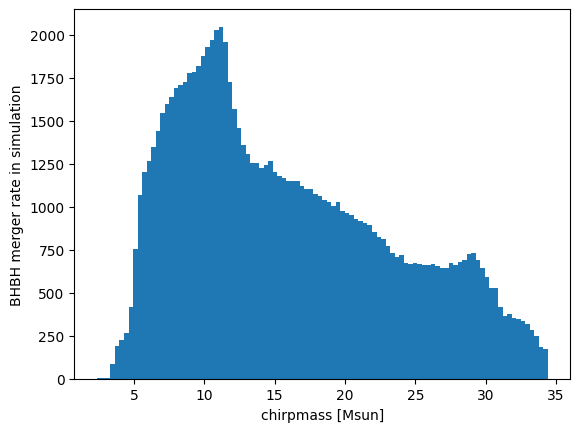

In [10]:
# to obtain the properties of the selected DCOtype you simply do this:

fDCO      = fdata['doubleCompactObjects']
#Stuff I need for cosmological integral


# at this moment we dont need to specify a mask, since our datafile has already taken this into account. 
DCOmask = [True]*(len(fDCO['Metallicity1'][...].squeeze()))
print(DCOmask)


metallicitySystems  = fDCO['Metallicity1'][...].squeeze()[DCOmask]  # Metallicity at ZAMS 
delayTimes          = fDCO['tform'][...].squeeze()[DCOmask] + \
                           fDCO['tc'][...].squeeze()[DCOmask]   # delay time 
tc                  = fDCO['tc'][...].squeeze()[DCOmask]  # coalescence time (or merger time)
M1              = fDCO['M1'][...].squeeze()[DCOmask]     # Compact object mass of star 1 
M2               = fDCO['M2'][...].squeeze()[DCOmask]    # Compact object mass of star 2 
m1zams              = fDCO['M1ZAMS'][...].squeeze()[DCOmask]   # Mass at ZAMS of star 1 
m2zams              = fDCO['M2ZAMS'][...].squeeze()[DCOmask]   # Mass at ZAMS of star 2 
separationzams      = fDCO['separationInitial'][...].squeeze()[DCOmask]   # separation at ZAMS of binary 


# we will use for this demo the weights from the simulation  ( you can change this to weights from Star formation history model xyz = '112')
weights = fdata['doubleCompactObjects']['weight'][...].squeeze() #fdata['weights_intrinsic']['w_112']




# change this to formation weights by uncommenting the following line:
# weights = fDCO['weight']


# other models can be chosen too. (there are more than 28 options currently)


def chirpmass(m1, m2):
    numer = (m1*m2)**(3./5)
    denom = (m1+m2)**(1./5)
    
    return numer/denom

# and you can plot properties, e.g., the chirpmass distribution: 
chirpmass =chirpmass(m1=M1, m2=M2)


plt.hist(chirpmass, bins=100, weights=weights)
plt.xlabel('chirpmass [Msun]')
plt.ylabel(r'BHBH merger rate in simulation')
# plt.title('weighted rate for astrophysical BH-NS merger populatio at redshift 0')
plt.show()




### M1 more massive, M2 least massive:






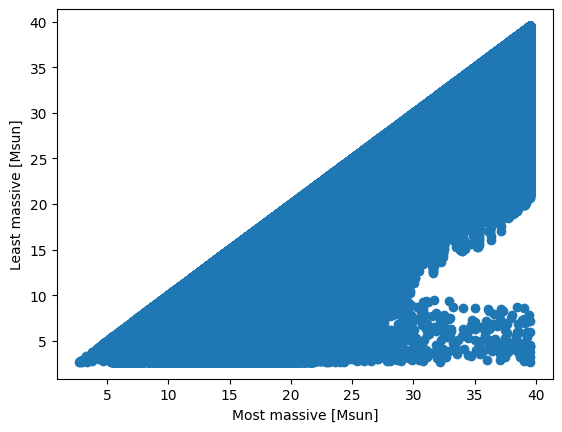

In [11]:
def obtainM1BHandM2BHassymetric(m1, m2):
    m1bh, m2bh = np.zeros_like(m1), np.zeros_like(m1)
    maskm1heavier = ( m1 >= m2)
    maskm2heavier = (m1 < m2)
    
    m1bh[maskm1heavier] = m1[maskm1heavier] 
    m1bh[maskm2heavier] = m2[maskm2heavier]
    m2bh[maskm1heavier] = m2[maskm1heavier]
    m2bh[maskm2heavier] = m1[maskm2heavier]
    
    return m1bh, m2bh # m1bh has all the heaviest systems



M_most_massive, M_least_massive = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)


plt.scatter(M_most_massive, M_least_massive)
plt.xlabel('Most massive [Msun]')
plt.ylabel('Least massive [Msun]')
plt.show()



### Metallicity 

the metallicity of each data point can be obtained with "metallicitySystems"
I used a total of 53 different metallicity bins, quoted in the bottem when printing "Data.metallicityGrid" 

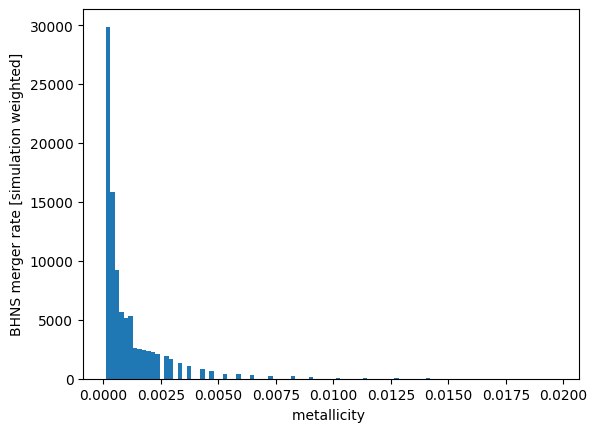

this mostly just shows my metallicity bins and where BHBH are originating from


In [12]:
# metallicitySystems = metallicitySystems
plt.hist(metallicitySystems, bins=100, weights=weights)
plt.xlabel('metallicity ')
plt.ylabel(r'BHNS merger rate [simulation weighted]')
# plt.title('weighted rate for astrophysical BH-BH merger populatio at redshift 0')
plt.show()




print('this mostly just shows my metallicity bins and where BHBH are originating from')

### Delay time  of each simulated data point in Myr

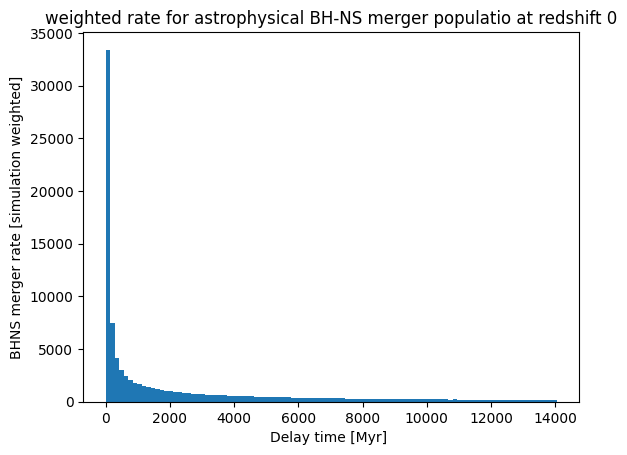

In [13]:


plt.hist(delayTimes, bins=100, weights=weights)
plt.xlabel('Delay time [Myr] ')
plt.ylabel(r'BHNS merger rate [simulation weighted]')
plt.title('weighted rate for astrophysical BH-NS merger populatio at redshift 0')
plt.show()




In [14]:
fdata.close()

### etc. etc. 
We have lots of options for parameters/properties of BHNS that one can plot. 
we can add spins, other weights and/or models for star formation history. 
and we can do the same thing for completely different models. 

# Redshift Rates:

# calculate and store the redshift rates:

run `python FastCosmicIntegration.py  --mu0 0.035 --muz -0.23 --sigma0 0.39 --sigmaz 0.0 --alpha 0.0 --weight mixture_weight --zstep 0.5 --sens O3 --m1min 10. --aSF 0.01 --bSF 2.77 --cSF 2.9 --dSF 4.7`

In [15]:
# path = full_data_path
# !python3 FastCosmicIntegration_large_files.py  --mu0 0.035 --muz -0.23 --sigma0 0.39 --sigmaz 0.0 --alpha 0.0 --weight mixture_weight --zstep 0.5 --sens O3 --m1min 10. --aSF 0.01 --bSF 2.77 --cSF 2.9 --dSF 4.7

In [16]:
import numpy as np
import h5py as h5
from astropy.table import Table, Column

import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt
from matplotlib import ticker, cm

from scipy import stats
import time 
import sys 

######################################
## set to the path where your BHNS data is stored ## 

DCOtype = 'BBH'   # You can change this line to 'BBH', 'BHNS' 'BNS', or 'ALL' (All DCOs)  # change this line! (but required downloading BBH/BNS data from Zenodo)
# fileLoc    =  '/Volumes/SimonsFoundation/DataDCO/fiducial/'
# # filename   = 'COMPASOutput.h5'
path = '/Volumes/SimonsFoundation/DataDCO/alpha0_5/COMPASCompactOutput_'+ DCOtype +'_H.h5' # change this line! [we can add the data to a cluster if you want!]


# full_data_path = path fileLoc + filename
######################################
##PLOT setttings
plt.rc('font', family='serif')

from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize






# Calculate and add redshift rates/weights: 

### The function below calculates the redshift rates on the spot. However, since its somewhat expensive, I wrote it so that you only have to run it once, after which it will append the redshift rates 
### it might be safer to copy paste this, and run it in your terminal (it might take a few minutes so get yourself some espresso :) ) 


Not that this example only attaches the redshift weights up to redshift ~1, and with a large resolution of only zstep ~ 1. You can change this, but it might become a very large datafile (hence why for this demo I didnt do it), so I would only save what you need to save :)

--dontAppend, if you uncomment this, it will not append the data at all. (which will save a LOT of time). -> if you dontAppend, it will also not complain about only saving data up to redshift 1 


##### total mass evolved per COMPAS simulation = 5413447143 Msun [note for Floor]

In [17]:



full_data_path = path

# you can also run this in your terminal -- you might have to change python3 to python
!python3 FastCosmicIntegration.py  \
--dco_type "BBH" \
--mu0 0.035 --muz -0.23 --sigma0 0.39 --sigmaz 0.0 --alpha 0.0 \
--weight 'weight' \
--zstep 1\
--sens O3 --m1min 10. \
--aSF 0.01 --bSF 2.77 --cSF 2.9 --dSF 4.7 \
--path $full_data_path \
--maxz 10 \
--maxzdet 10 \
--maxz_append 1 \ 
# --dontAppend 



path= /Volumes/SimonsFoundation/DataDCO/alpha0_5/COMPASCompactOutput_BBH_H.h5
using dcotype:  BBH
m1 m2 [44.7734 78.0567 46.0732 ... 82.8811 67.8482 82.2285] 
 [23.6305 67.2047 30.7426 ... 58.3113 49.9849 58.6777]
/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/demo_read_hdf5_file/COSMIC_Scripts_DCO_data/FastCosmicIntegration.py:914: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  detection_rate, formation_rate, merger_rate, redshifts, COMPAS = find_detection_rate(args.path, dco_type=args.dco_type, weight_column=args.weight_column,
n_binaries 7954356
DONE with long loop
Appending your freshly calculated merger rates to the hdf5 file
shape redshifts (11,)
shape COMPAS.sw_weights (7954356,)
COMPAS.DCOmask [ True  True  True ...  True  True  True]  was set for dco_type BBH
shape COMPAS COMPAS.DCOmask (7954356,)
shape DCO[SEED] (7954356, 1)
Rates_mu00.035_muz-

In [18]:
print(full_data_path)

/Volumes/SimonsFoundation/DataDCO/alpha0_5/COMPASCompactOutput_BBH_H.h5


In [19]:
# Uncomment this below and copy paste it to run in terminal (instead of in juputer notebook)
# python FastCosmicIntegration.py  --dco_type "BHNS" --mu0 0.035 --muz -0.23 --sigma0 0.39 --sigmaz 0.0 --alpha 0.0 --weight 'weight' --zstep 0.01 --sens O3 --m1min 10. --aSF 0.01 --bSF 2.77 --cSF 2.9 --dSF 4.7 --path "fill_in_path"


In [21]:




################################################
## Open hdf5 file
File        = h5.File(full_data_path ,'r')

print(File.keys())

# The group that contains the rate data
rate_key = 'Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0'
################################################
## Read merger rate related data
print(File[rate_key].keys())
redshifts                 = File[rate_key]['redshifts'][()] # Redshifts at which the rates were calculated
merger_rate_z0_per_system = File[rate_key]['merger_rate_z0'][()] # detection rate for O3 sensitivity 
total_rate_z0 = np.sum(merger_rate_z0_per_system) # this is the rate for redshift 0, you can get the rate for all redshifts by summing over merger_rate

# # Read the DCO masses, Select only merging BBHs
Mass1              = File['doubleCompactObjects']['M1'] # reads in the mass in [Msun] 
Mass2              = File['doubleCompactObjects']['M2'] # reads in the mass in [Msun] 
M_moreMassive      = np.maximum(Mass1, Mass2)
M_lessMassive      = np.minimum(Mass1, Mass2)
del Mass1
del Mass2 

print(total_rate_z0, '[Gpc^-3 yr^_1]')

File.close()

<KeysViewHDF5 ['RLOF', 'Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0', 'commonEnvelopes', 'doubleCompactObjects', 'formationchannel_z_rates', 'redshifts', 'supernovae', 'systems', 'weights_intrinsicFormationPerRedshift', 'weights_intrinsicPerRedshift']>
<KeysViewHDF5 ['DCOmask', 'SEED', 'merger_rate', 'merger_rate_z0', 'redshifts']>
9.175423616395815 [Gpc^-3 yr^_1]


In [22]:
File        = h5.File(full_data_path ,'r')

print(File['Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0'].keys())



w_0 = File['Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0']['merger_rate_z0'][...].squeeze()

print(w_0)
redshifts = File['Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0']['redshifts'][...].squeeze()
print('available redshifts are: ', redshifts, ' this gives %s options'%len(redshifts))

w_per_z_per_system = File['Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0']['merger_rate'][...].squeeze()

print(np.shape(w_per_z_per_system))

z_index = 1

print('the redshift weights per system at z = ', redshifts[z_index], ' are given by' )
w_z_index =w_per_z_per_system[:,z_index]




<KeysViewHDF5 ['DCOmask', 'SEED', 'merger_rate', 'merger_rate_z0', 'redshifts']>
[7.38170570e-43 1.59281062e-43 1.94317828e-43 ... 2.87860846e-03
 5.29334940e-03 2.87566249e-03]
available redshifts are:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]  this gives 11 options
(7954356, 2)
the redshift weights per system at z =  1.0  are given by


## Plot BH-BH histogram of a quantity at chosen redshift z 

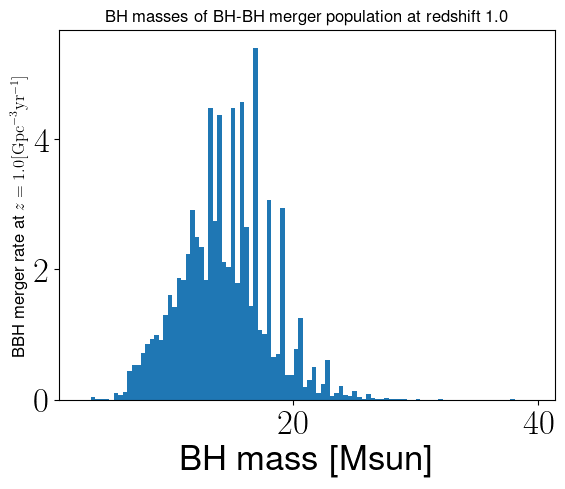

In [23]:



plt.hist(M_moreMassive, bins=100, weights=w_z_index)
plt.xlabel('BH mass [Msun] ')
plt.ylabel(r'BBH merger rate at $z =%s [\rm{Gpc}^{-3} \rm{yr}^{-1}]$'%np.round(redshifts[z_index],3), fontsize=12)
plt.title('BH masses of BH-BH merger population at redshift %s'%np.round(redshifts[z_index],3), fontsize=12)
plt.show()



## Plot intrinsic redshift rate

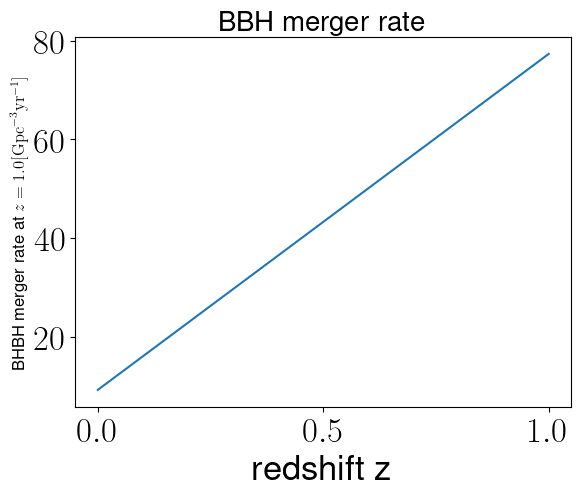

In [24]:

plt.plot(redshifts[:2], np.sum(w_per_z_per_system, axis=0)) # change "2" if you actually ran the weights for more redshifts (here its only for 0 and 1, ie beyond  >2)
plt.xlabel('redshift z')
plt.ylabel(r'BHBH merger rate at $z =%s [\rm{Gpc}^{-3} \rm{yr}^{-1}]$'%np.round(redshifts[z_index],3), fontsize=12)
plt.title('BBH merger rate', fontsize=20)
plt.show()

In [25]:




File.close()